In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

Open data

In [2]:
filepath = r'../image segmentation/CT_scan.npy'
img = np.load(filepath)

In [3]:
img.shape

(263, 512, 512)

Plot slice of the image:

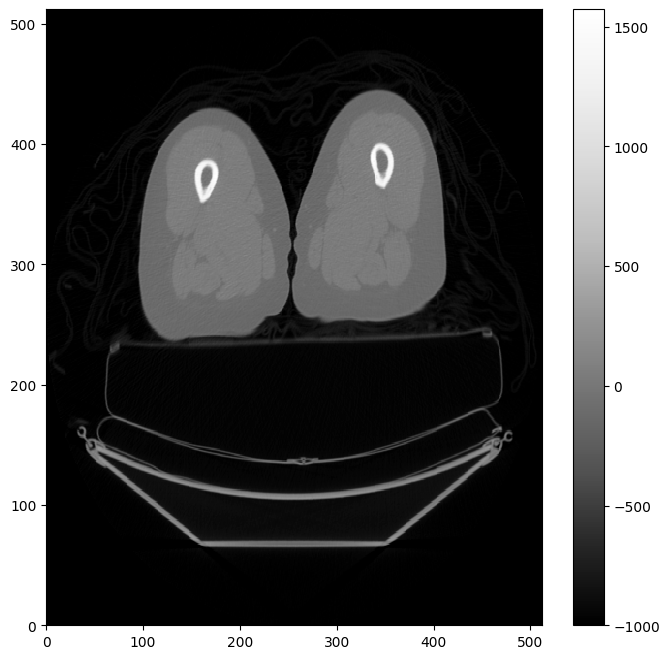

image for:  0


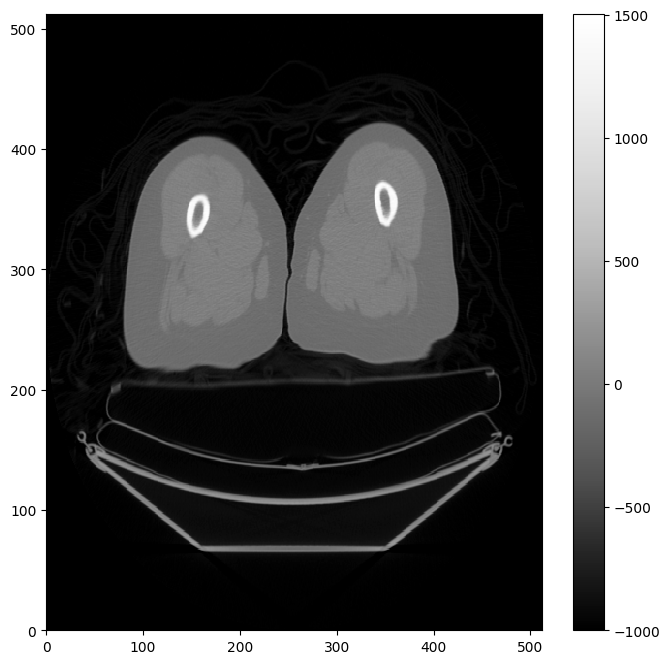

image for:  10


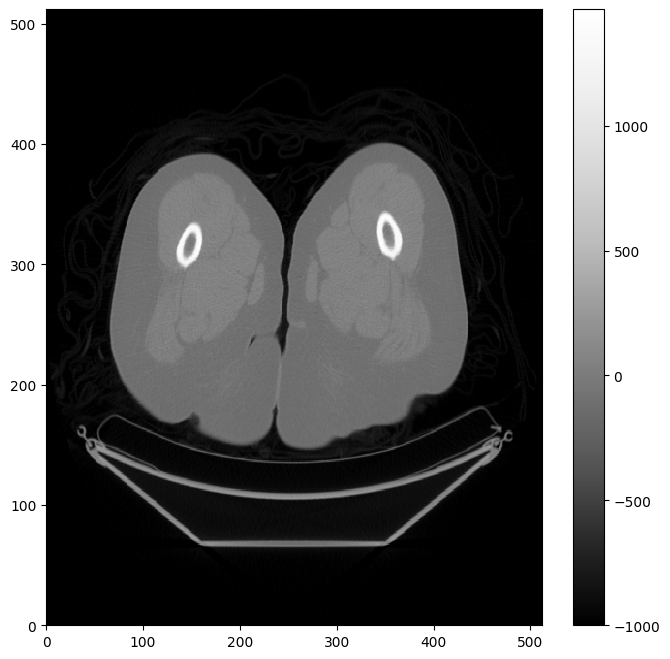

image for:  20


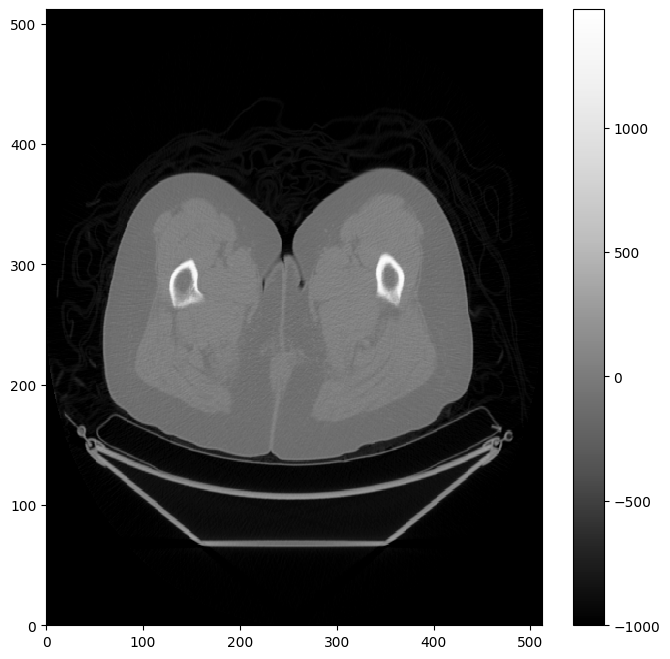

image for:  30


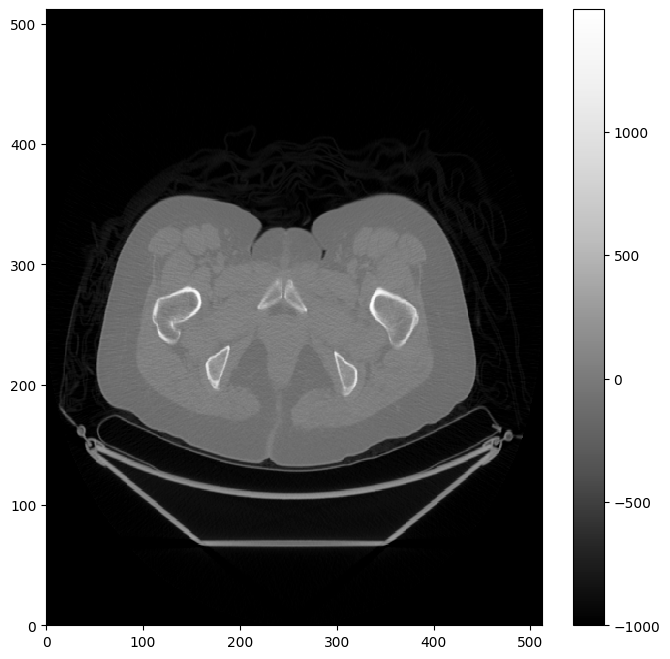

image for:  40


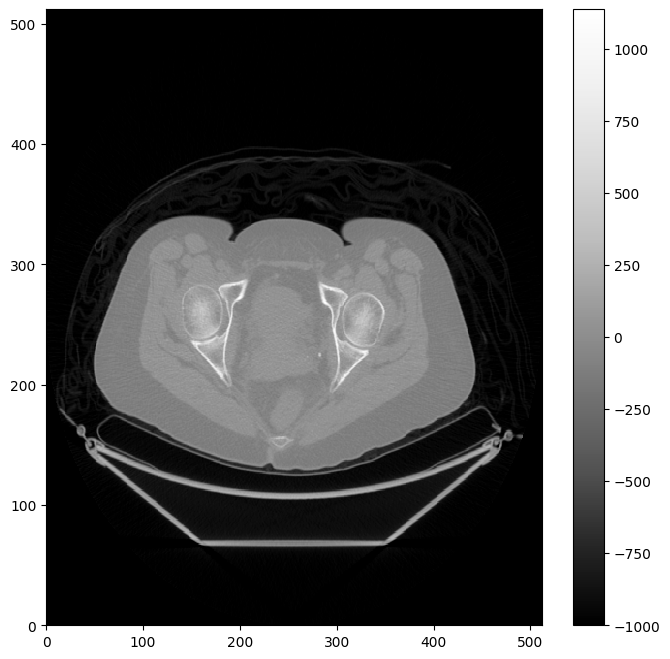

image for:  50


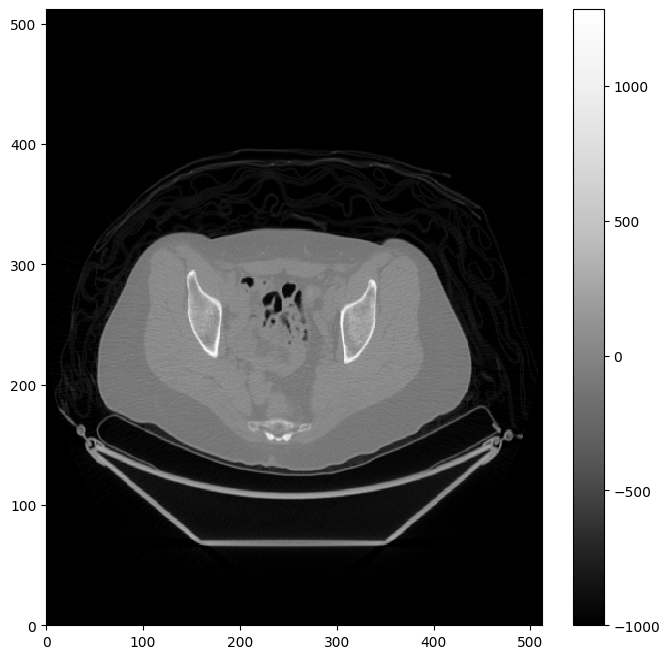

image for:  60


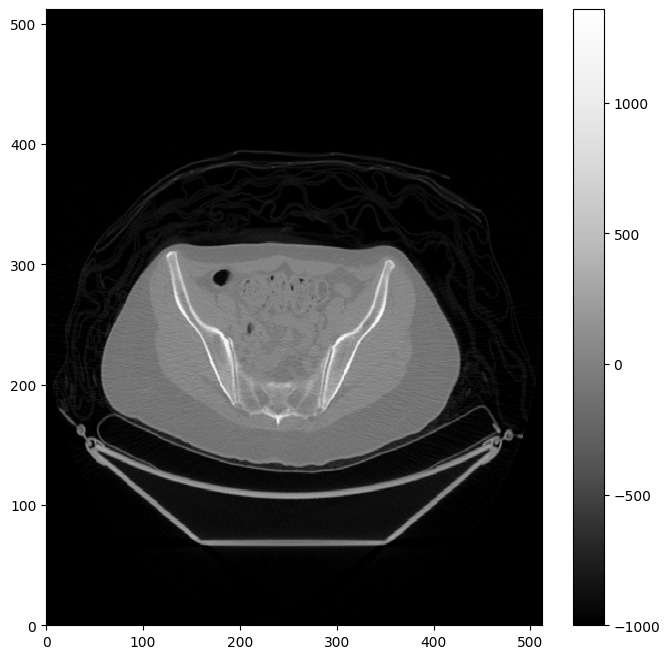

image for:  70


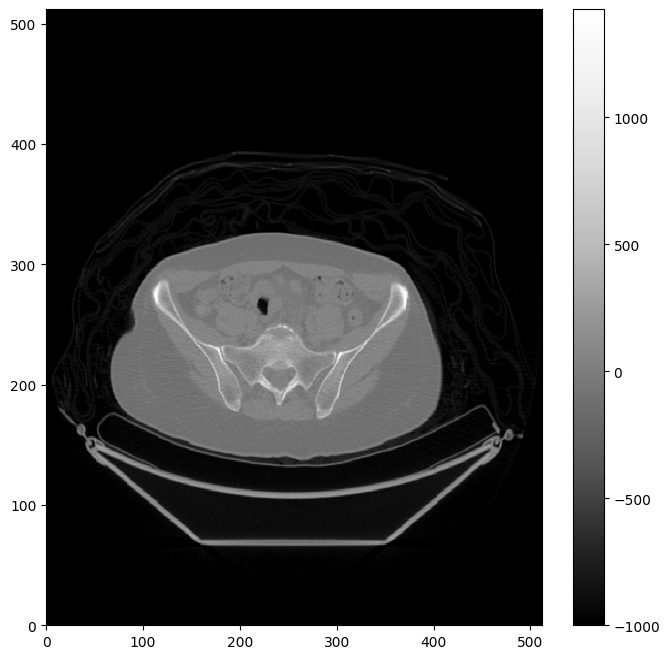

image for:  80


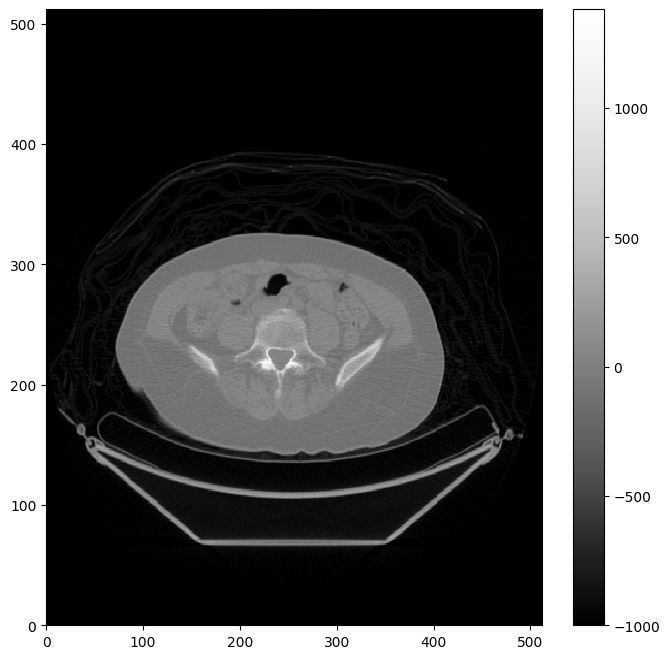

image for:  90


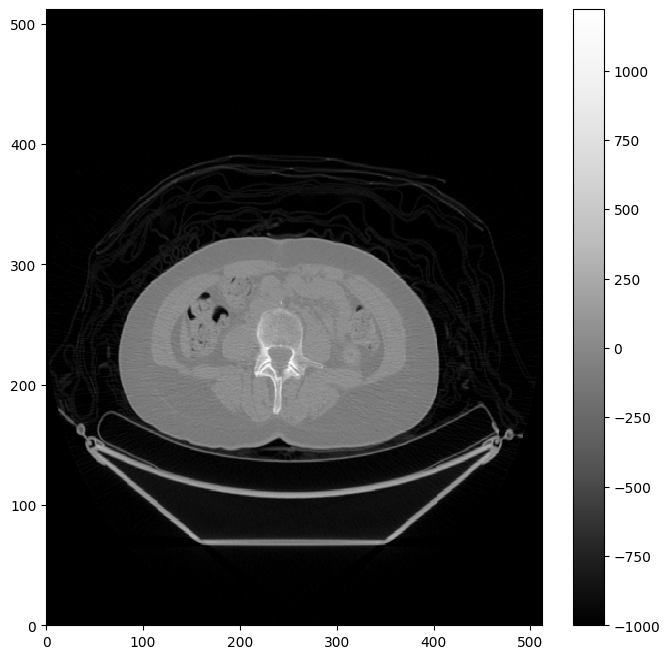

image for:  100


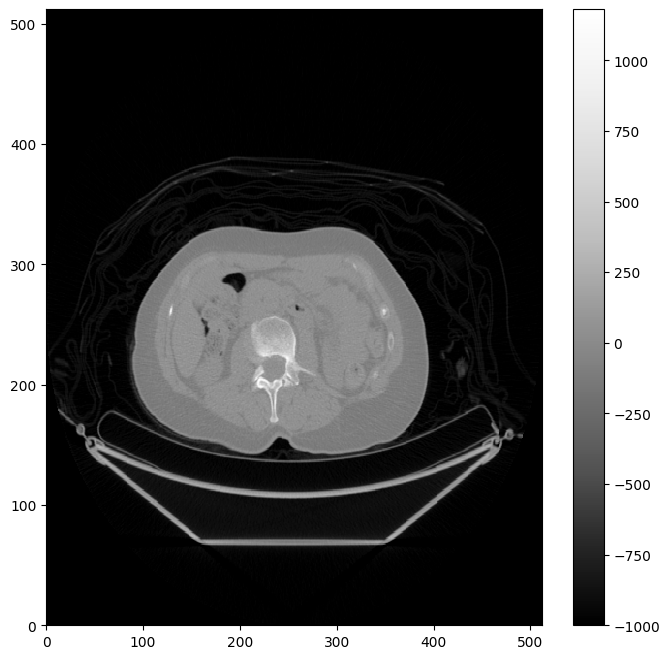

image for:  110


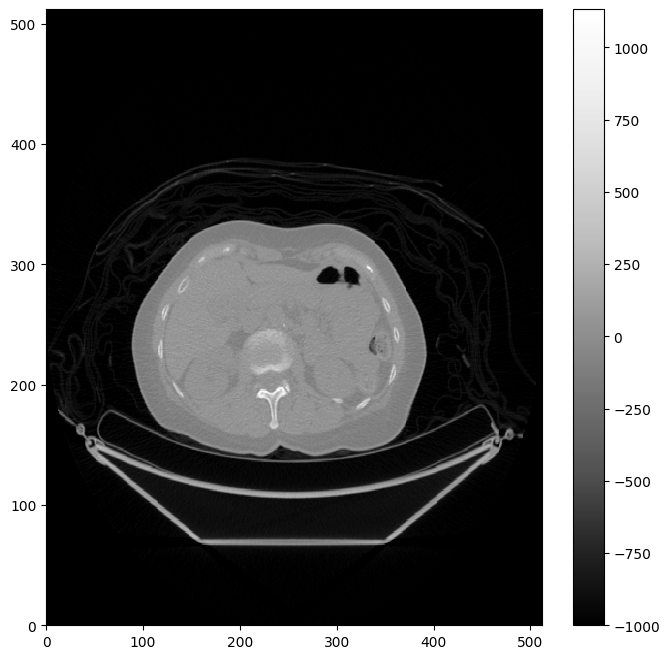

image for:  120


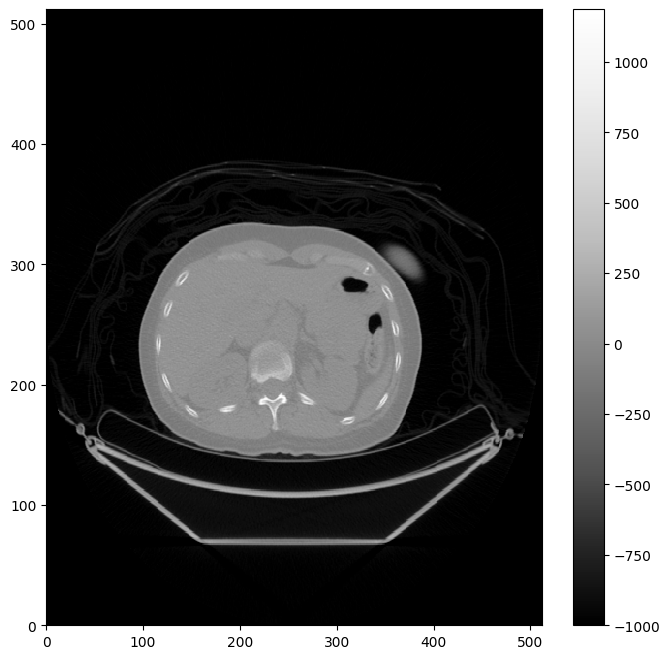

image for:  130


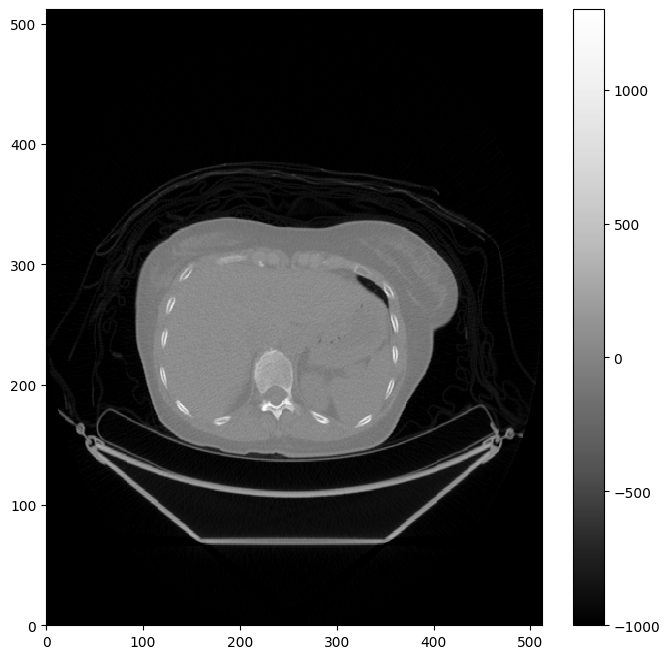

image for:  140


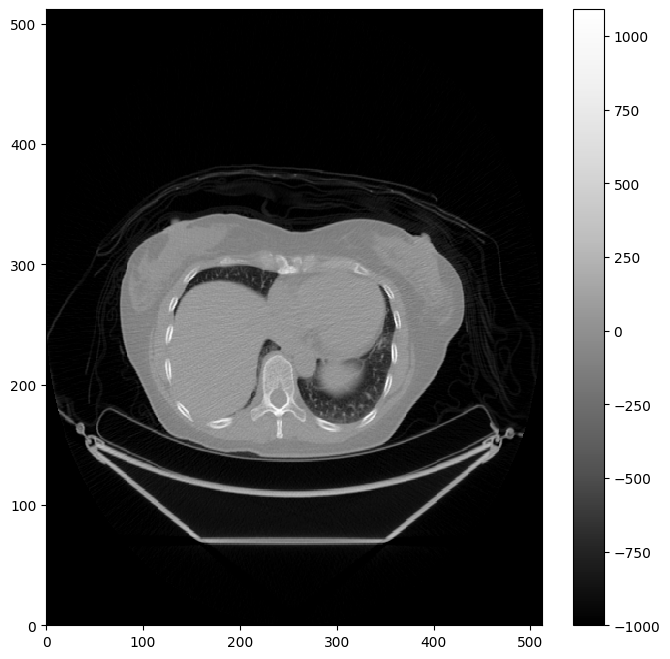

image for:  150


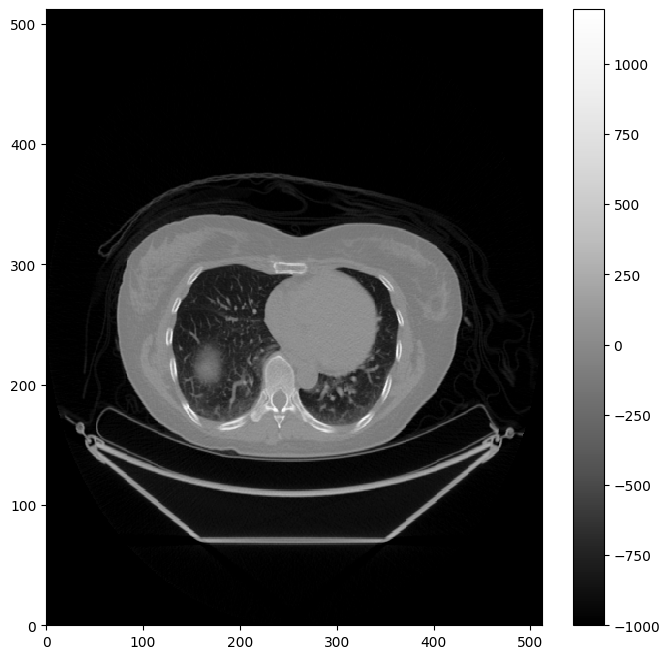

image for:  160


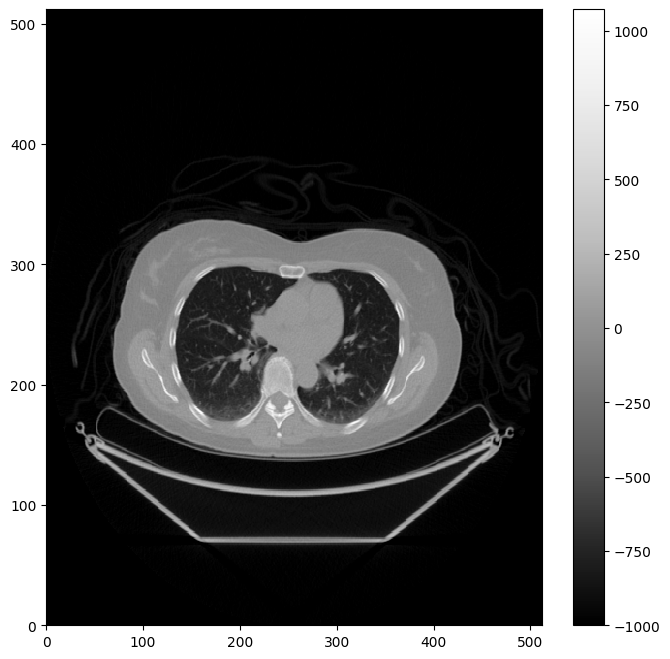

image for:  170


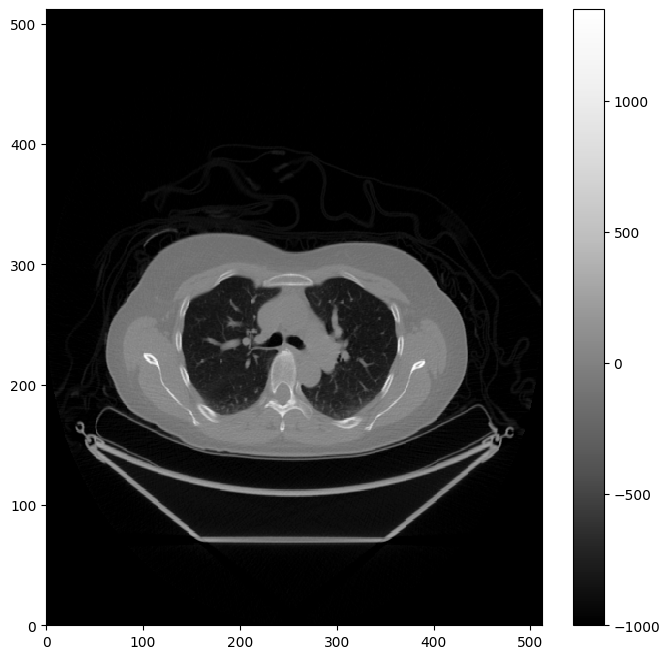

image for:  180


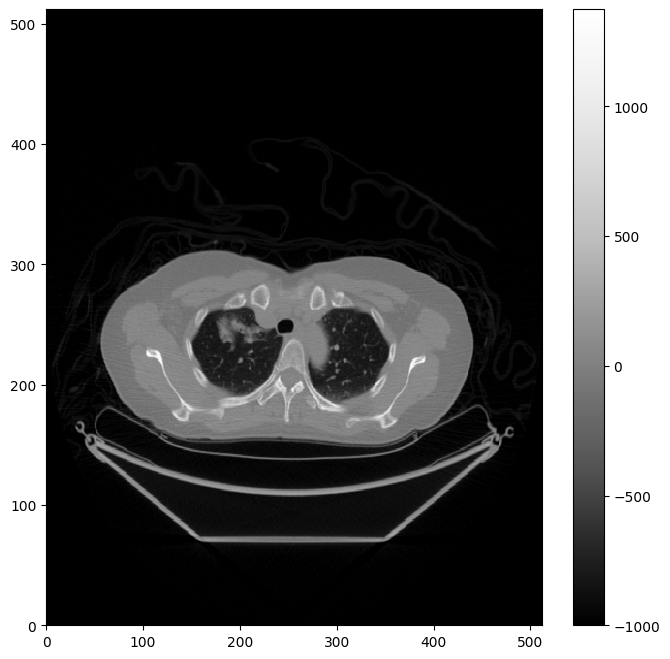

image for:  190


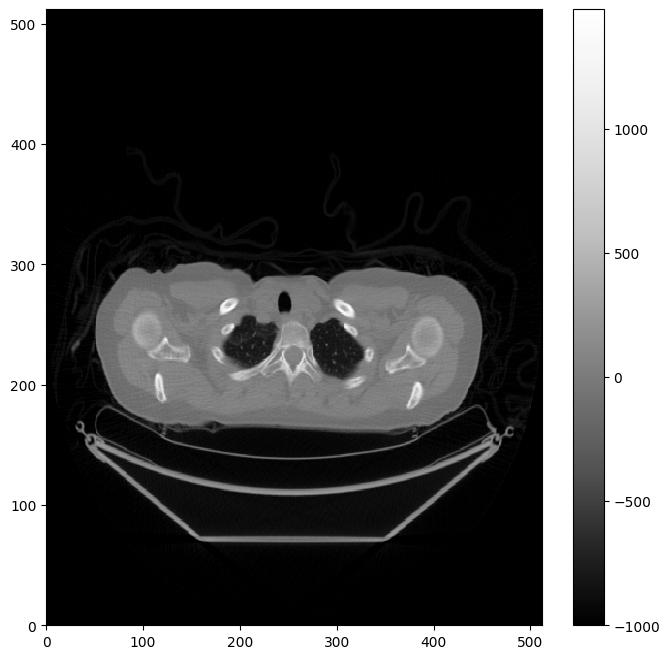

image for:  200


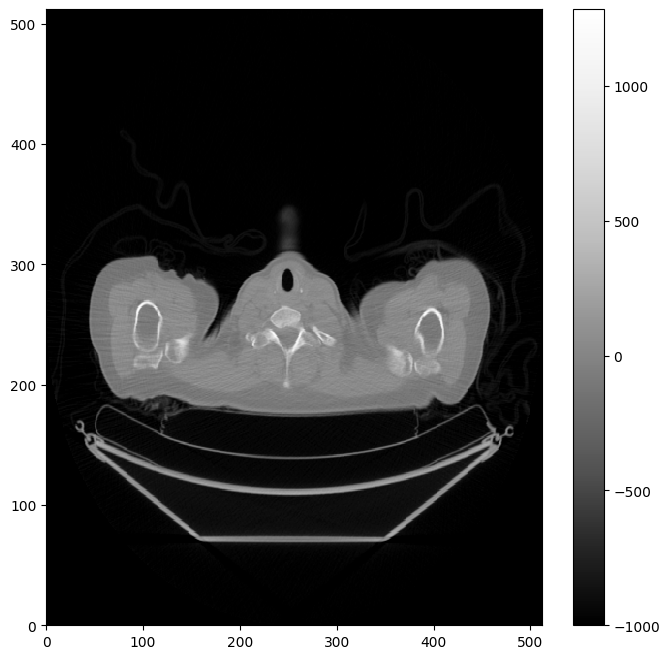

image for:  210


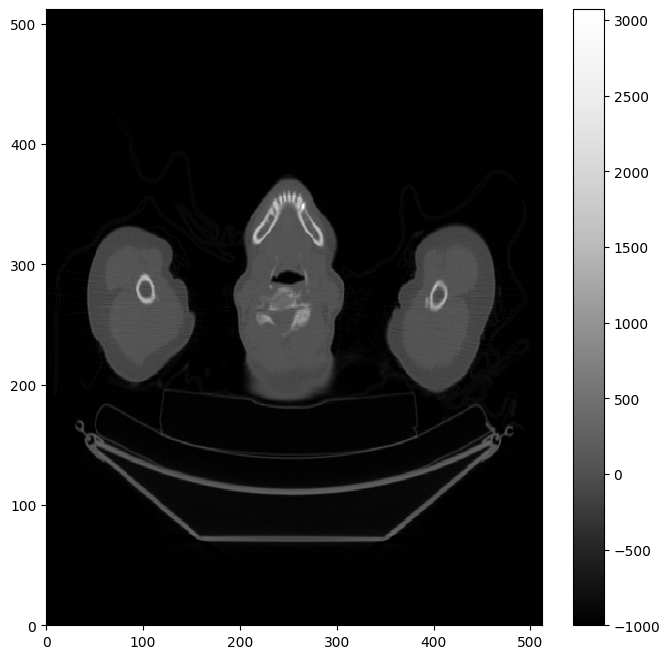

image for:  220


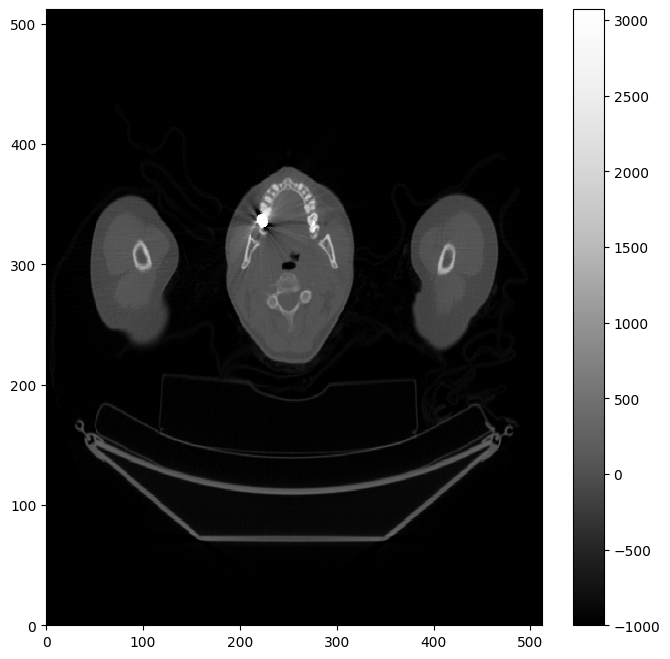

image for:  230


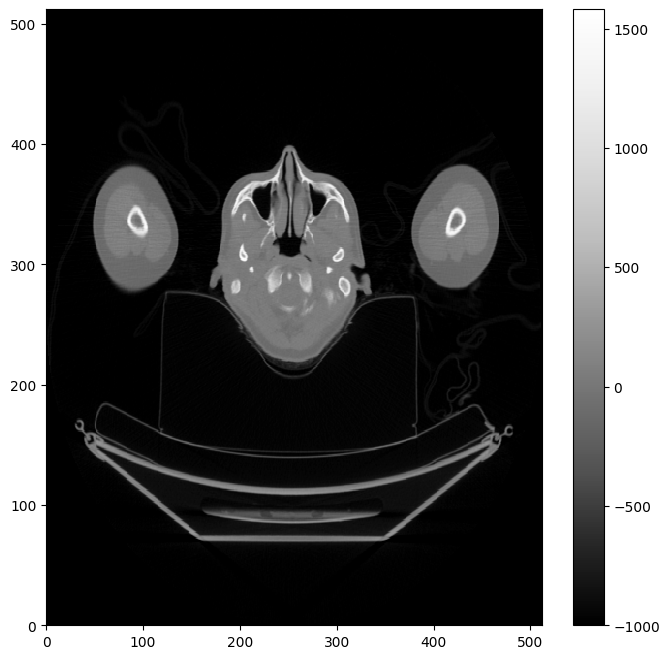

image for:  240


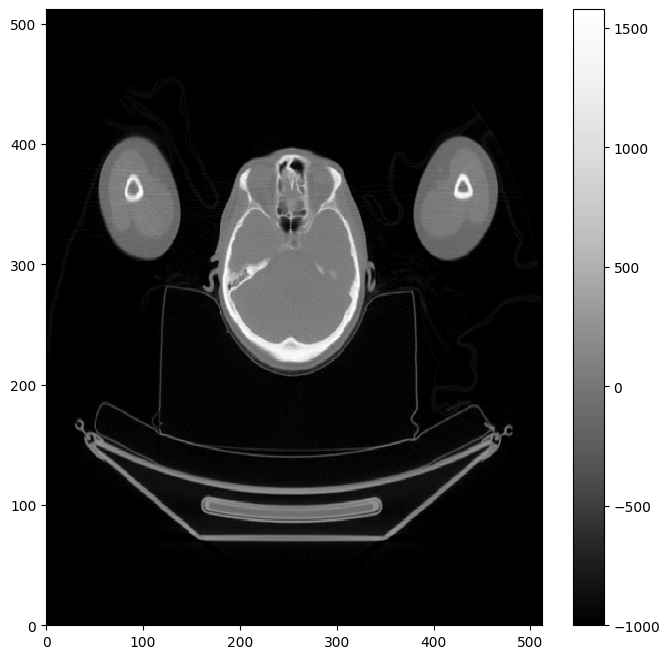

image for:  250


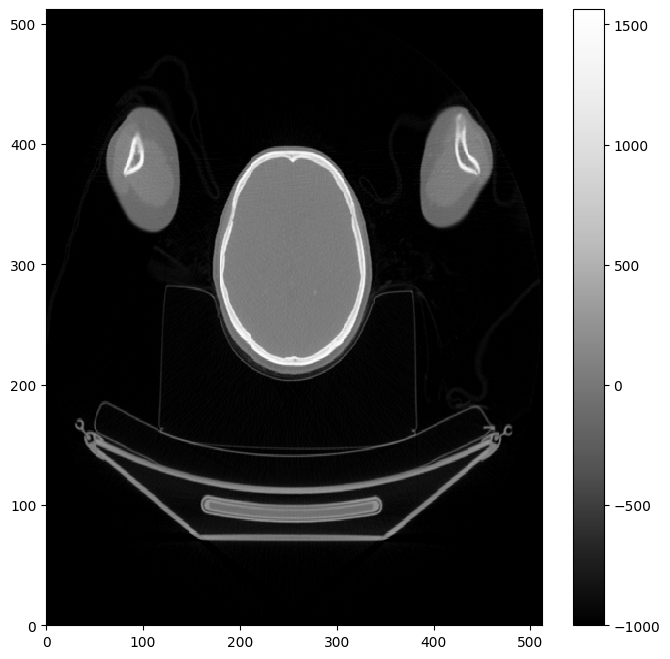

image for:  260


In [23]:
for i in range(0,270,10):
    plt.figure(figsize=(8,8))
    plt.pcolormesh(img[i], cmap='Greys_r')
    plt.colorbar()
    plt.show()
    print('image for: ',i)

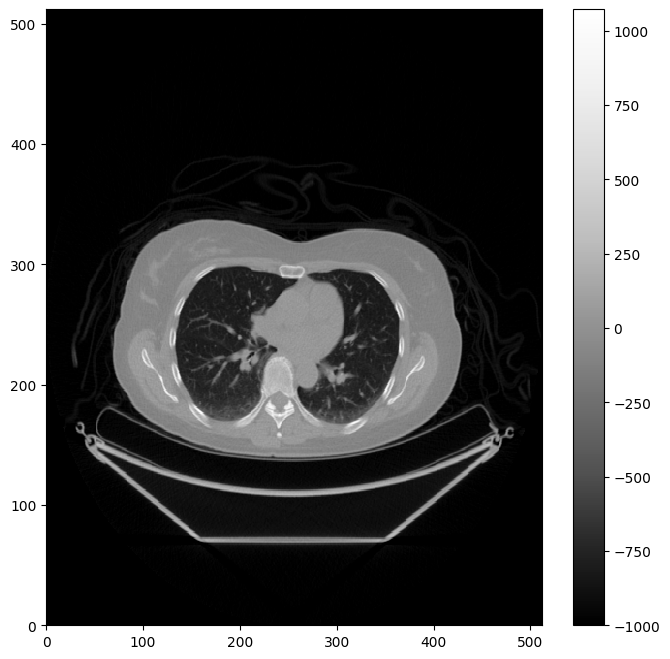

image for:  170


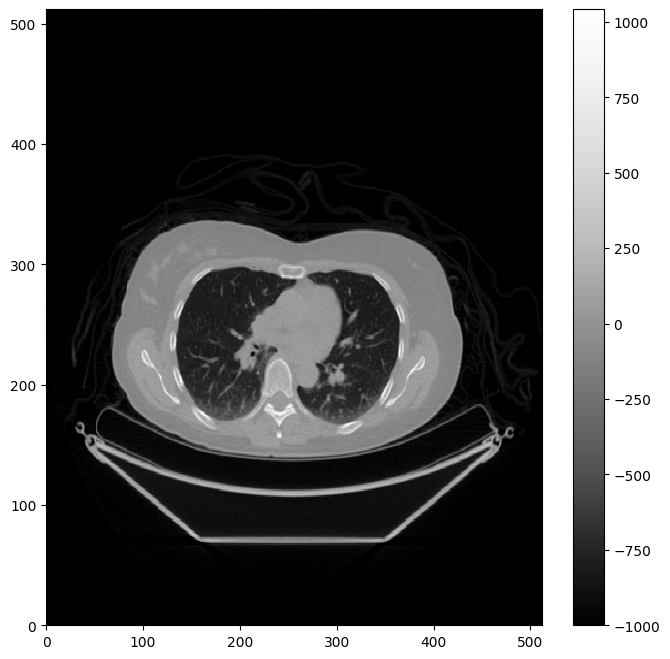

image for:  171


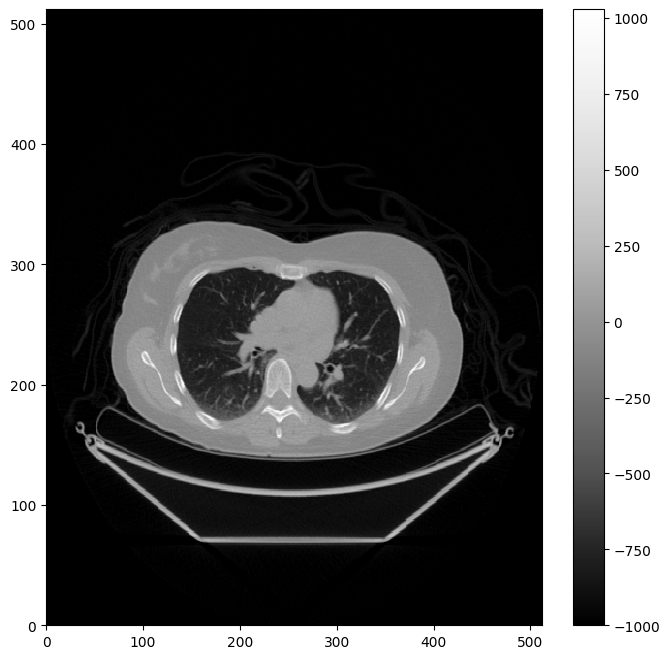

image for:  172


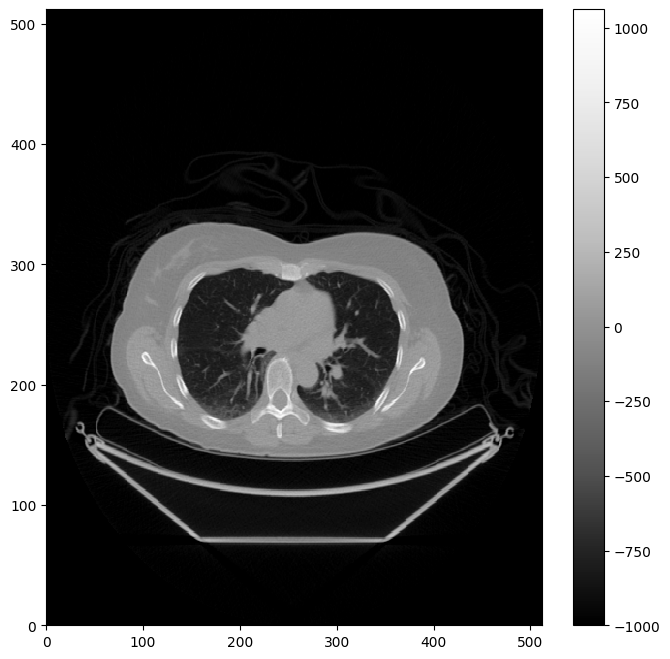

image for:  173


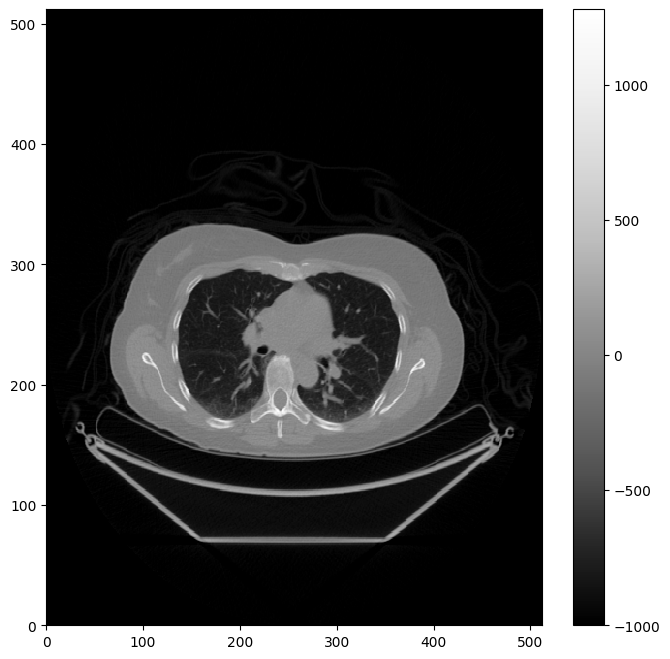

image for:  174


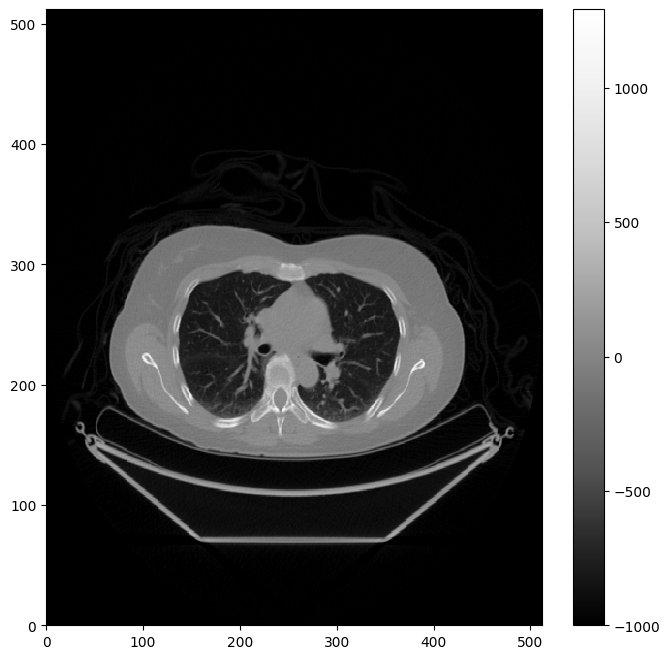

image for:  175


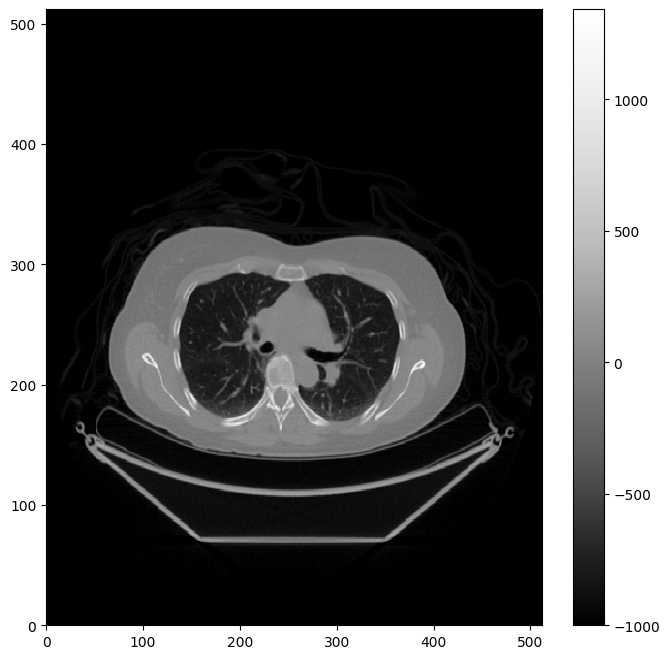

image for:  176


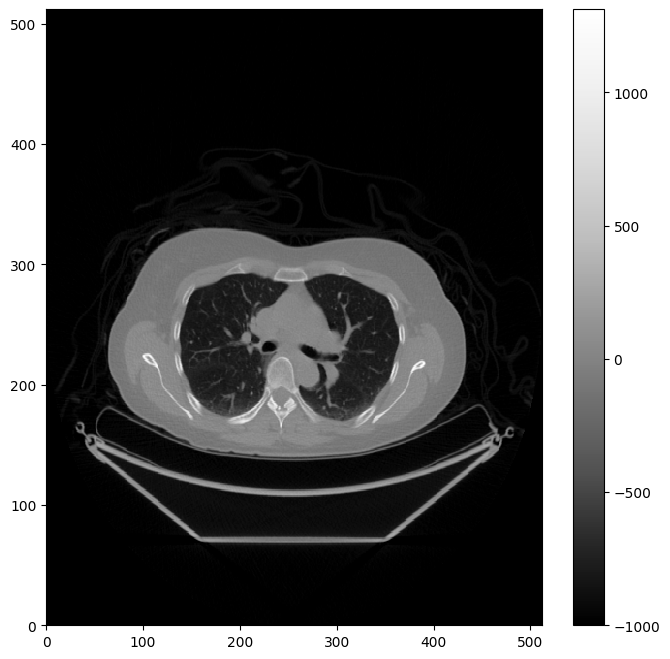

image for:  177


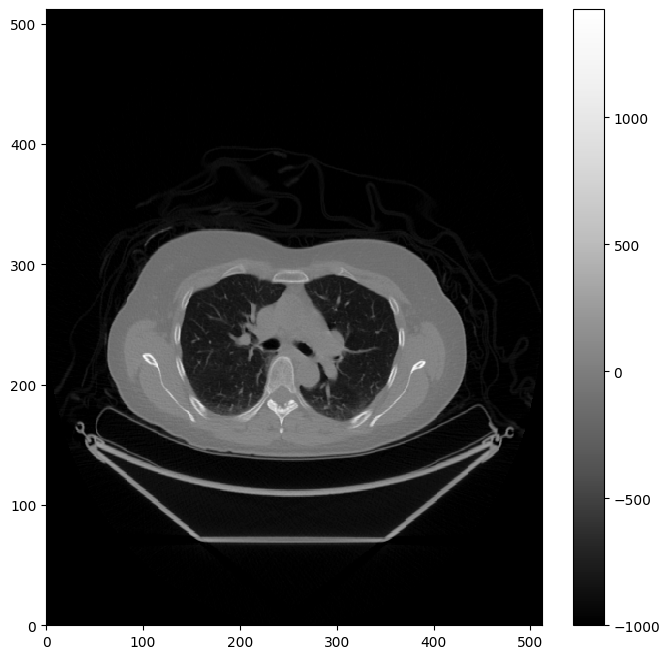

image for:  178


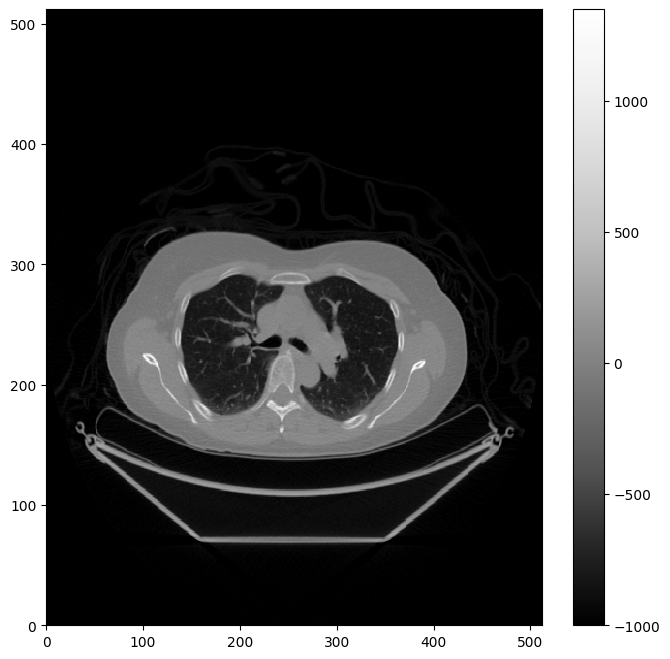

image for:  179


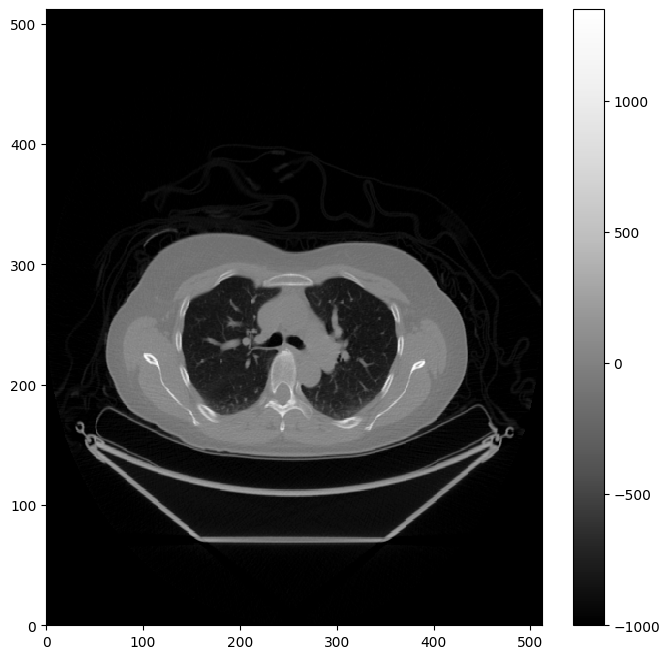

image for:  180


In [24]:
for i in range(170,181):
    plt.figure(figsize=(8,8))
    plt.pcolormesh(img[i], cmap='Greys_r')
    plt.colorbar()
    plt.show()
    print('image for: ',i)

What do these units mean? The pixel values of this CT scan are expressed in Hounsfield Units

$$HU(x,y) \equiv 1000 \cdot \frac{\mu(x,y) - \mu_{\text{water}}}{\mu_{\text{water}}-\mu_\text{air}}$$

where $\mu$ is the linear attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_0e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies $\approx 100$keV. Here are typical HU values:

<p align="center">
  <img src="HU.PNG" alt="drawing" width="600" align="center"/>
</p>

# Modify data

The first thing to note is that air is signifcantly less HU than other substances in the body, so we apply a so-called "threshhold" mask. Lets use -320 HU as the lower limit:

In [25]:
mask = img < -320

Plot the mask

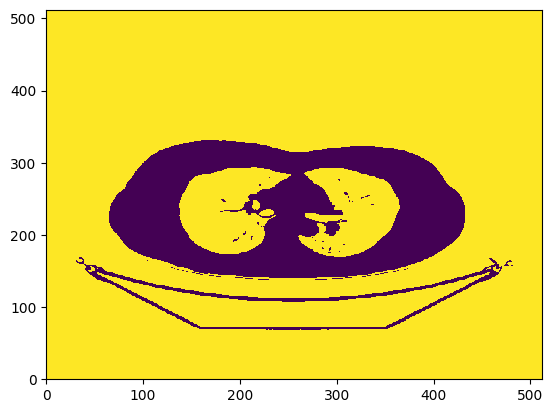

In [26]:
plt.pcolormesh(mask[176])

Next we can use the `clear_border` function to remove the outer border:

In [27]:
mask.shape

(263, 512, 512)

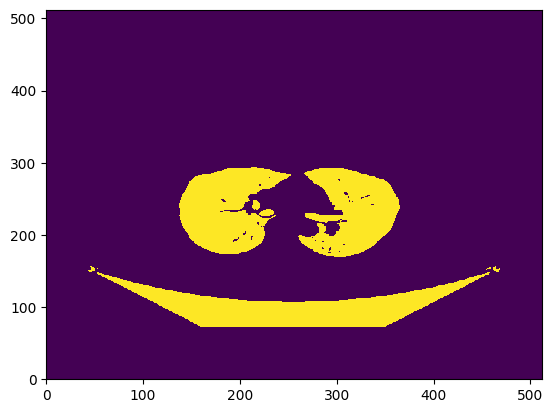

In [28]:
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask[176])

Now we'll give each seperate volume a different integer value using the `label` function

In [29]:
mask.shape

(263, 512, 512)

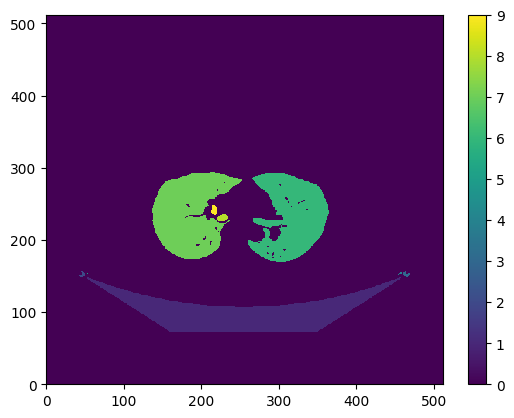

In [30]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled[176])
plt.colorbar()

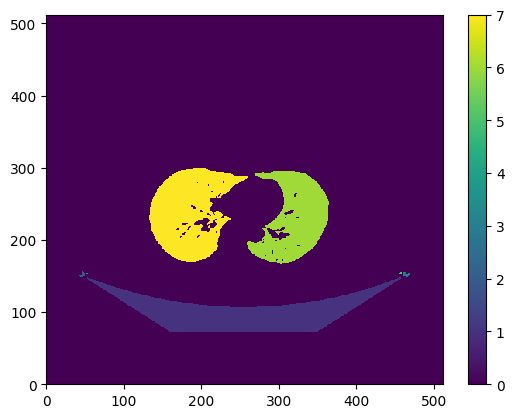

In [31]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled[170])
plt.colorbar()

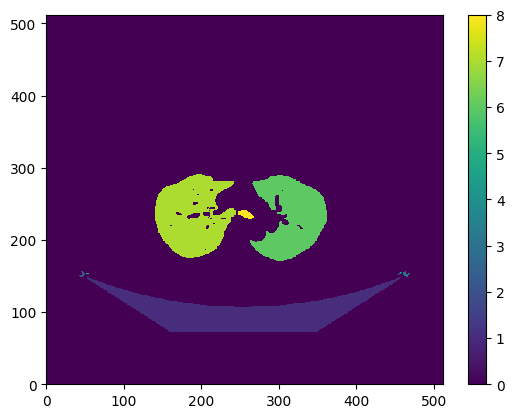

In [32]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled[180])
plt.colorbar()

Now for something a little non-intuitive. We want to keep the three largest areas for each slice of the image. Why would we want to do this if we only want to keep the two lungs?

* In some slices one of the lungs could be larger than the table
* In some slices one of the lungs could be smaller than the table

If we only take the largest two slices, we might end up taking the table and one of the lungs. So for now lets take the top 3. The function below is designed to operate on a single slice of the 3D image:

In [34]:
slc = mask_labeled[176] #selecting the slice

In [35]:
rps = regionprops(slc) # taking properties of the different regeions in image

In [36]:
areas = [r.area for r in rps] # finding the area of the each region of properties

In [37]:
areas

[11547.0, 34.0, 35.0, 7.0, 1.0, 8078.0, 8768.0, 115.0, 85.0]

In [43]:
idxs=np.argsort(areas)[::-1] # sorting areas from largest to smallest
print(idxs)

[0 6 5 7 8 2 1 3 4]


Only consider the 3 largest areas (iterating theough `idxs`). Add these areas to a new slice called `new_slc`:

In [40]:
new_slc = np.zeros_like(slc)
new_slc.shape

(512, 512)

In [44]:
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)] = i+1

Plot 

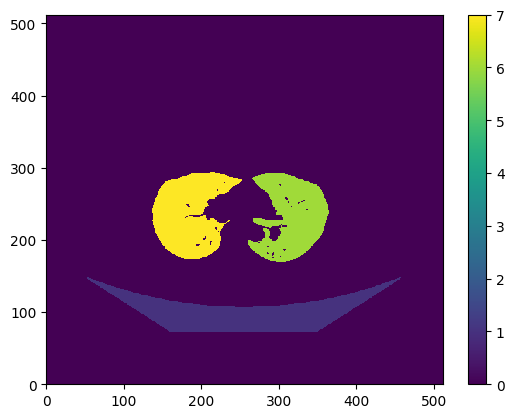

In [45]:
plt.pcolormesh(new_slc)
plt.colorbar()

Now lets automate this for all slices in our 3D image:

In [46]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [47]:
mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)

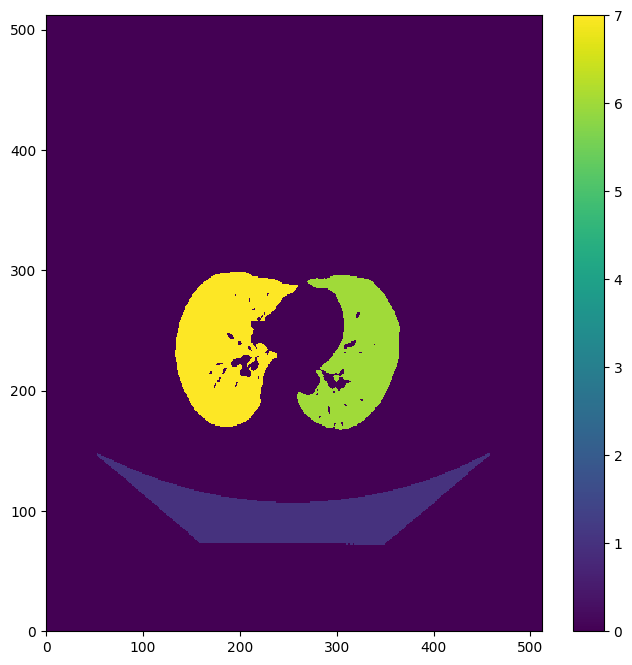

image for:  170


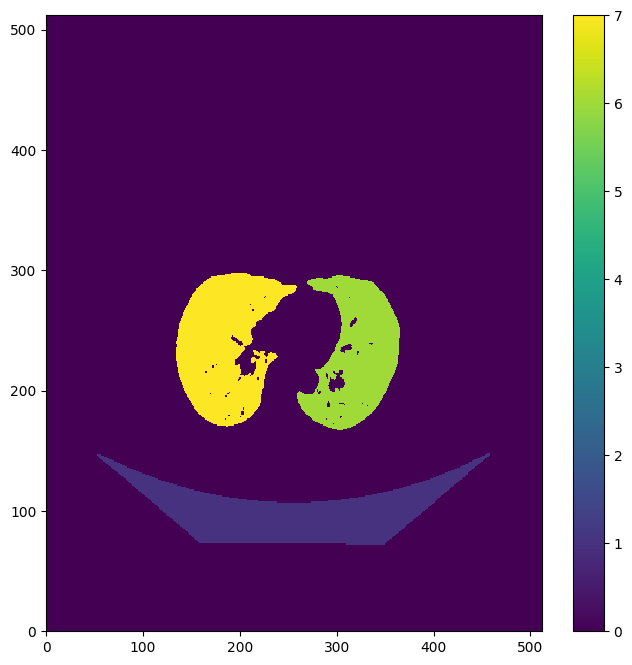

image for:  171


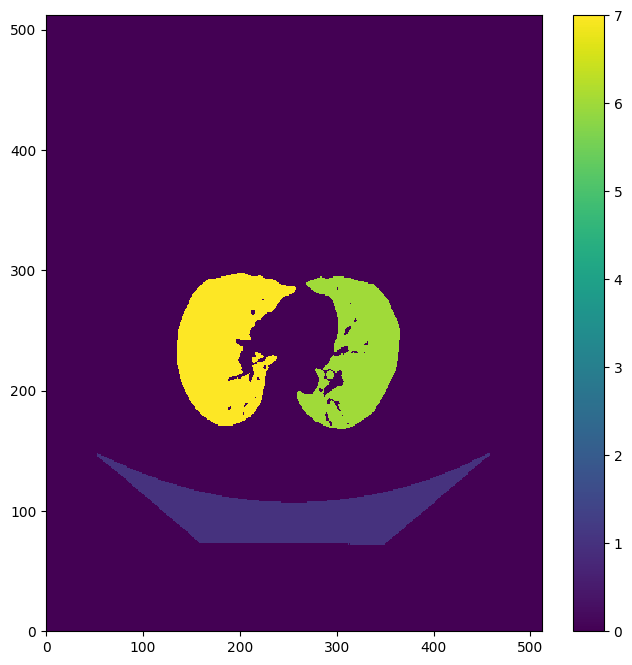

image for:  172


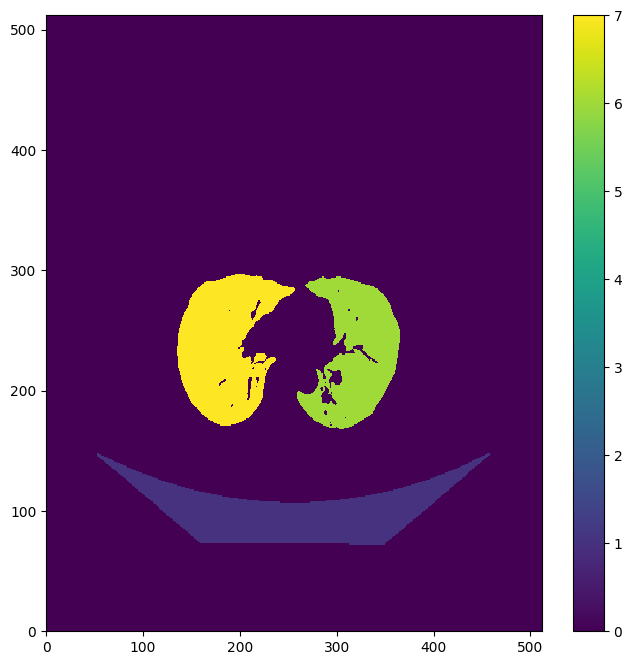

image for:  173


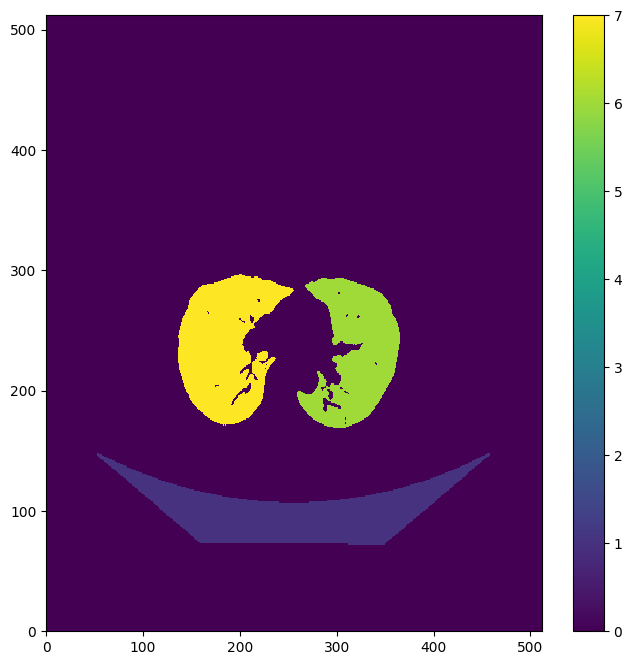

image for:  174


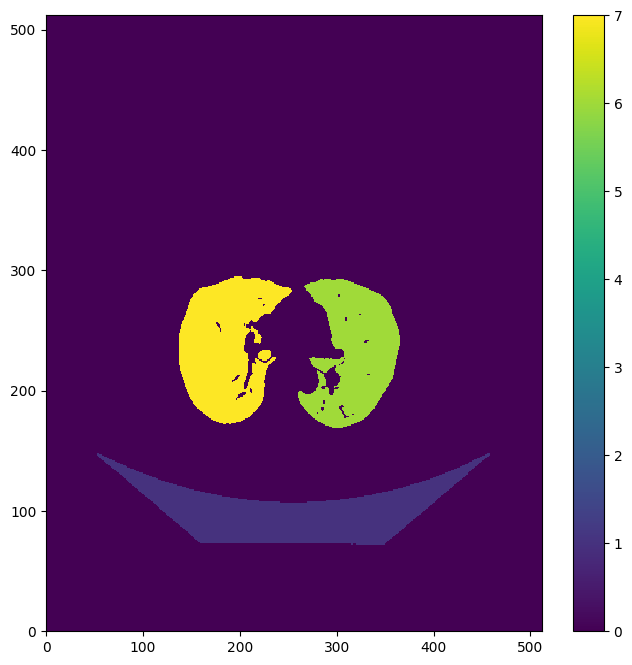

image for:  175


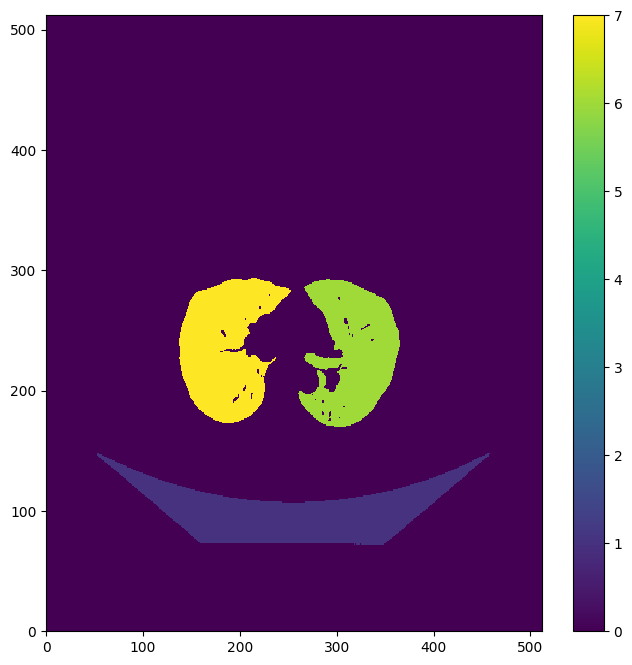

image for:  176


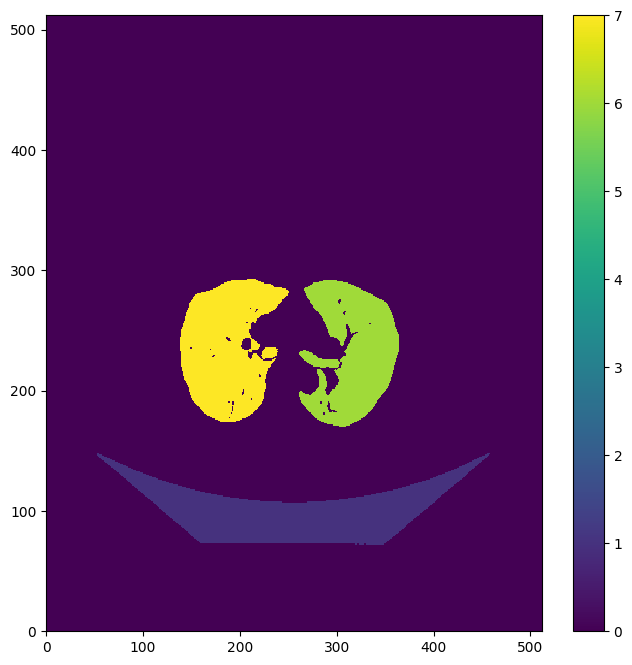

image for:  177


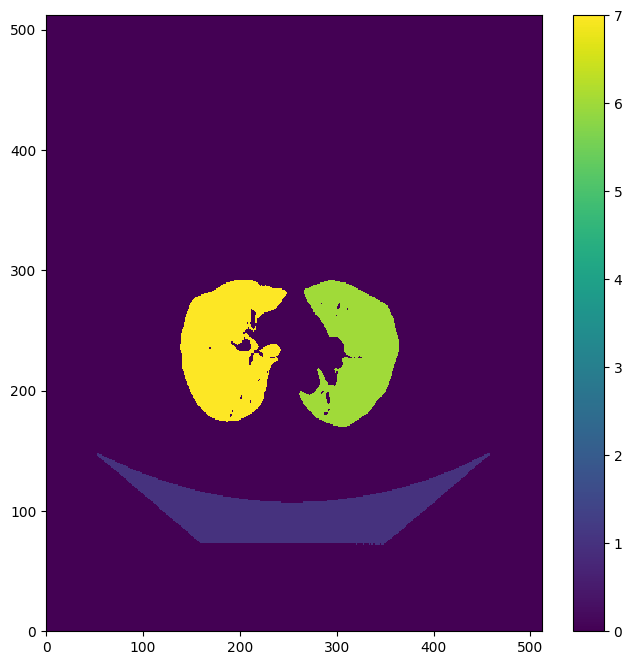

image for:  178


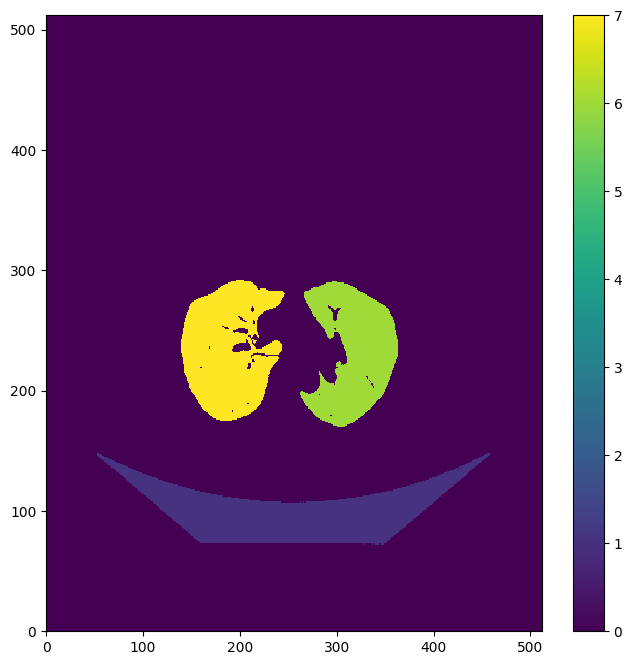

image for:  179


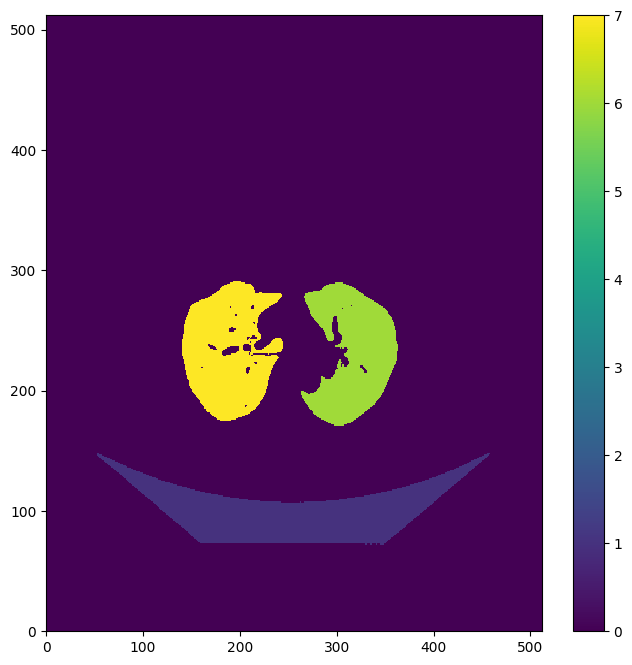

image for:  180


In [48]:
for i in range(170,181):
    plt.figure(figsize=(8,8))
    plt.pcolormesh(mask_labeled[i])
    plt.colorbar()
    plt.show()
    print('image for: ',i)

Now lets fill in any small holes in the lungs:

In [49]:
mask = mask_labeled > 0

In [50]:
mask.shape

(263, 512, 512)

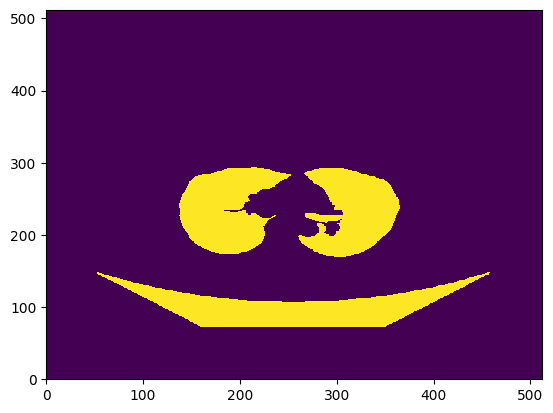

In [54]:
sl=ndi.binary_fill_holes(mask[176])
plt.pcolormesh(sl)

In [52]:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask) # vectorize function is kind of a loop

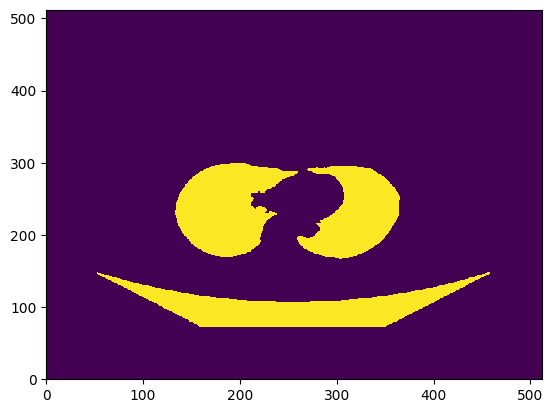

In [55]:
plt.pcolormesh(mask[170])

In some slices, the trachea is kind of annoying and we need to remove it:

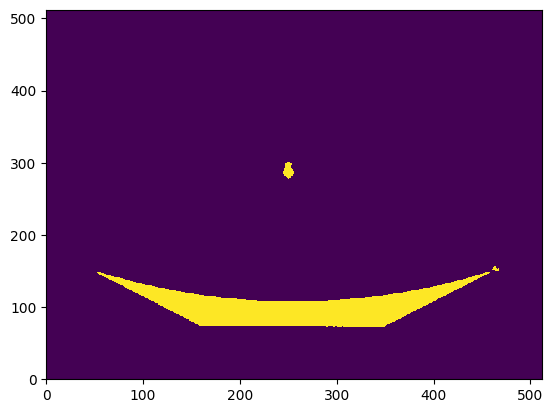

In [56]:
plt.pcolormesh(mask[-50])

here the center blob i actually hole in original image bcoz of trachea

In a 512x512 image, the trachea typically takes up less than 0.69% of the area. We can delete all regions that have any area smaller than this percentage:

In [57]:
mask[-50]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [58]:
labels = label(mask[-50],connectivity=1,background=0)

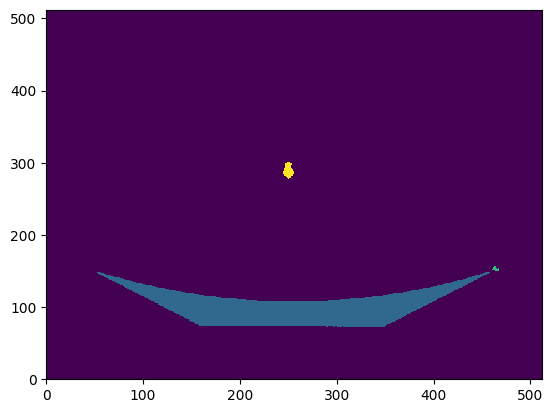

In [59]:
plt.pcolormesh(labels)

In [60]:
rps = regionprops(labels)

In [61]:
rps

In [62]:
areas = np.array([r.area for r in rps])

In [63]:
areas

array([11534.,    33.,   170.])

In [65]:
np.where(areas/512**2 < 0.0069) # thus 2 areas are smaller than 0.69% of image

(array([1, 2]),)

In [66]:
def remove_trachea(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [67]:
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)

Now the trachea is removed in the slice we were considering:

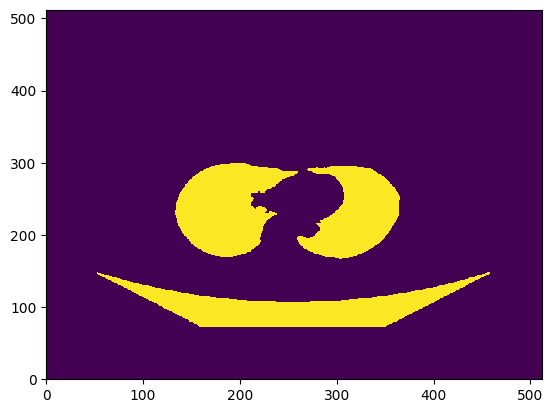

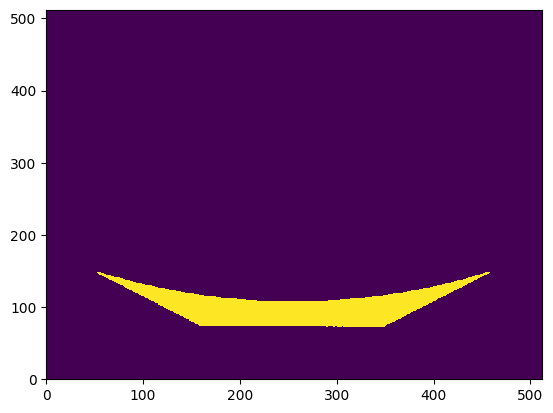

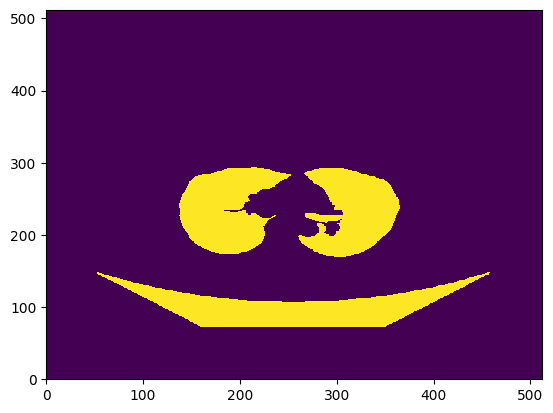

In [69]:
plt.pcolormesh(mask[170])
plt.show()
plt.pcolormesh(mask[-50])
plt.show()
plt.pcolormesh(mask[176])
plt.show()

Finally, its time to remove the table. Note that the center of mass of the table is always lower than the two lungs. As such, we simply need to delete the volume with the lowest center of mass in $y$ to delete the table:

In [70]:
labels = label(mask[176], background=0)

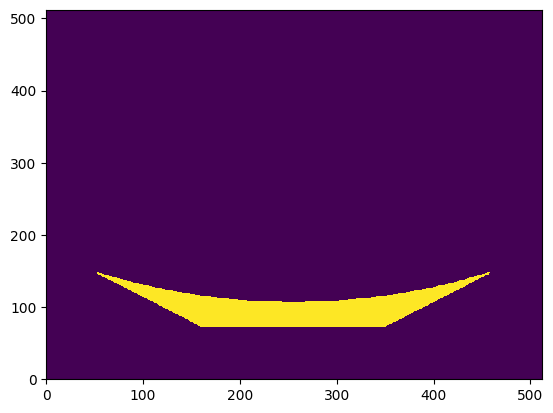

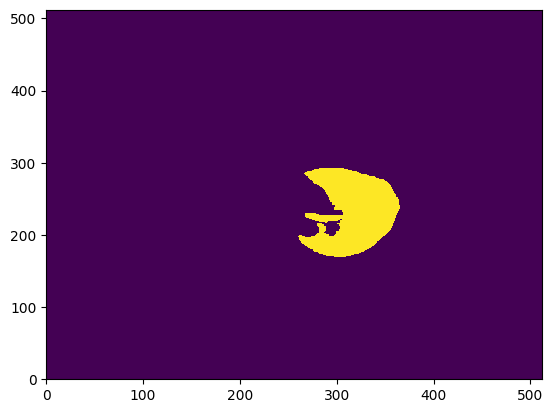

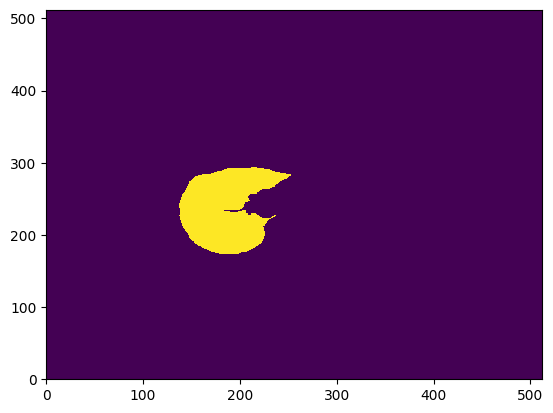

In [86]:
plt.pcolormesh(labels==1)
plt.show()
plt.pcolormesh(labels==2)
plt.show()
plt.pcolormesh(labels==3)
plt.show()

Plot a slice of the labels with the masks:

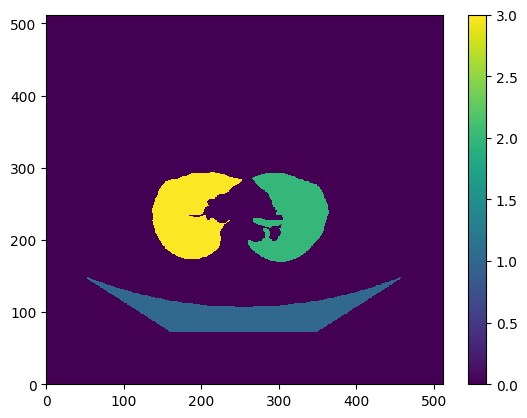

In [71]:
plt.pcolormesh(labels)
plt.colorbar()

Compute the center of masses in this slice:

In [87]:
center_of_mass(labels==3)

(235.2890121081815, 185.24714269548488)

In [88]:
center_of_mass(labels==3)[0]

235.2890121081815

In [91]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]): # for parts like tables and thighs,etc.
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]): # for parts above lungs like nose, etc
            new_slc[labels==idx] = 0
    return new_slc

In [74]:
mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)

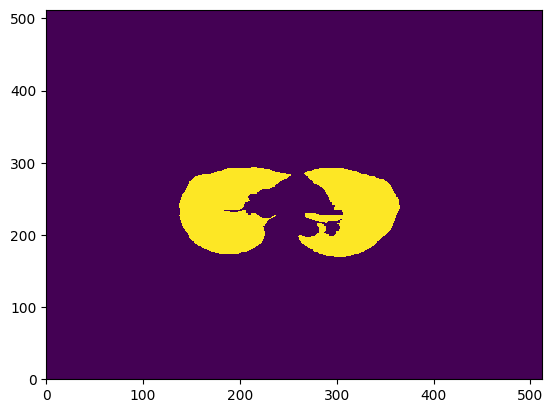

In [75]:
plt.pcolormesh(mask_new[176])

Finally, we can expand the area of the lungs a little bit by growing the border. For this, we can use the `binary_dilation` function:

In [94]:
mask_new = binary_dilation(mask_new, iterations=3)

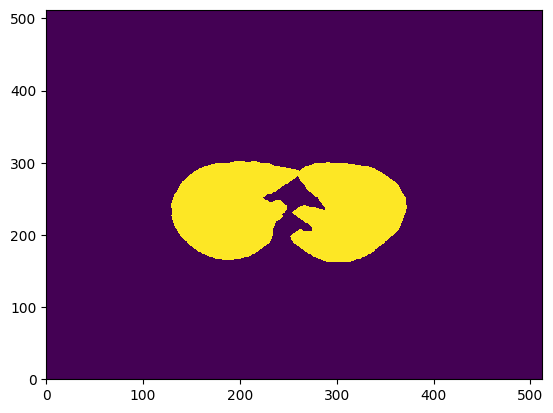

In [95]:
plt.pcolormesh(mask_new[176])

Lets plot the full 3D image in plotly and create an interactive plot:

* First decrease the resolution a little bit:

In [96]:
im = zoom(1*(mask_new), (0.4,0.4,0.4))

In [97]:
im.shape

(105, 205, 205)

Get arrays of $x$, $y$, and $z$. In a CT scan, the difference between pixels in the z direction is about 4 times bigger than in the $x$ and $y$ directions:

In [98]:
z, y, x = [np.arange(i) for i in im.shape]
z*=4

Create a meshgrid:

In [99]:
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

Create a 3D plotly plot

In [101]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.write_html("test2.html")

In [102]:
img_new = mask_new * img

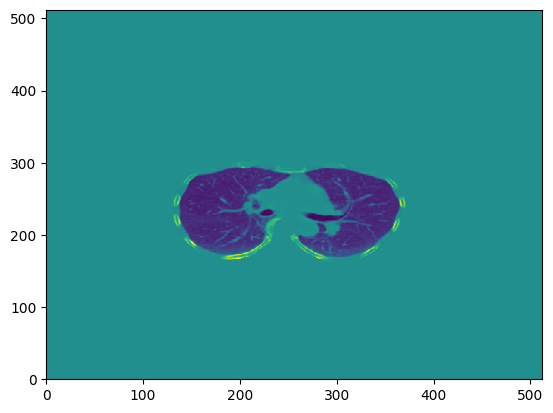

In [103]:
plt.pcolormesh(img_new[176])